In [77]:
from osgeo import ogr 
import os 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
ogr.UseExceptions()


In [78]:
gso_folder = "/media/riannek/minimax/gleis/gso"
gso_layers = [
"5556_km8,5-30,5+5560_km27,2-29,9_Run14.csv",
"5560_km27-33.2+5556_km8.6-33_Run24_ohne_Flughafentunnel.csv",
]
gso_file = "gso.gpkg"
tmp_folders = [
    "/media/riannek/minimax/gleis/temp_run14",
    "/media/riannek/minimax/gleis/temp_run24",
]
runs = [
    "run14",
    "run24",
]
tmp_file = "temp.gpkg"

driver = ogr.GetDriverByName("GPKG")

Das folgende bis zur Überschrift zum Zeit sparen überspringen (und Daten aus CSV lesen)

In [79]:
run_id = 1 # 0 = run14, 1 = run24

ds_gso = driver.Open(os.path.join(gso_folder, gso_file), 1)
layer_gso = ds_gso.GetLayer(gso_layers[run_id])
layer_gso.GetFeatureCount()

28268

In [80]:
ds_lines = driver.Open(os.path.join(tmp_folders[run_id], tmp_file), 1)
layer_lines = ds_lines.GetLayer("centerlines")
layer_lines.GetFeatureCount()

159

In [81]:
# Remove fields if they exist and create new fields
new_fields = ["distance", "delta_z", "abs_delta_z"]

for field_name in new_fields:
    field_index = layer_gso.GetLayerDefn().GetFieldIndex(field_name)
    if field_index >= 0:
        layer_gso.DeleteField(field_index)

# Create new fields
for field_name in new_fields:
    layer_gso.CreateField(ogr.FieldDefn(field_name, ogr.OFTReal))

In [82]:
def distance_and_delta_z(point25d_feature, line_layer, max_distance=0.10):
    point25d = point25d_feature.GetGeometryRef()
    px, py, pz = point25d.GetX(), point25d.GetY(), point25d.GetZ()

    # Create a 2D buffer to filter candidates (10 cm default)
    buffer_geom = ogr.Geometry(ogr.wkbPoint)
    buffer_geom.AddPoint(px, py)
    buffer_geom = buffer_geom.Buffer(max_distance)

    line_layer.SetSpatialFilter(buffer_geom)

    # find closest line in 2D among candidates
    min_dist = float("inf")
    closest_feature = None
    for feature in line_layer:
        line_geom = feature.GetGeometryRef()
        dist_2d = line_geom.Distance(point25d)
        if dist_2d < min_dist:
            min_dist = dist_2d
            closest_feature = feature.Clone()

    line_layer.SetSpatialFilter(None)  

    # compute Z difference for the closest vertex
    delta_z = None
    if closest_feature:
        line_geom = closest_feature.GetGeometryRef()
        best_vertex_dist = float("inf")
        best_z = None
        for i in range(line_geom.GetPointCount()):
            x, y, z = line_geom.GetPoint(i)
            d2 = (px - x)**2 + (py - y)**2
            if d2 < best_vertex_dist:
                best_vertex_dist = d2
                best_z = z
        delta_z = pz - best_z

    return min_dist, delta_z



In [83]:
distances = []
z_deltas = []

for feature in layer_gso:
    distance, z_delta = distance_and_delta_z(feature, layer_lines)
    if distance is not None and z_delta is not None:
        distances.append(distance)
        z_deltas.append(z_delta)
        feature.SetField("distance", distance * 1000)
        z_delta_mm = z_delta * 1000
        feature.SetField("delta_z", z_delta_mm)
        feature.SetField("abs_delta_z", abs(z_delta_mm))
        layer_gso.SetFeature(feature)

distances = np.array(distances)
z_deltas = np.array(z_deltas)

In [84]:
df = pd.DataFrame({
    'distance': distances * 1000,
    'z_delta': z_deltas * 1000
})
df['abs_z_delta'] = df['z_delta'].abs()
df.to_csv(f"compare_gedoscanoffice_{runs[run_id]}.csv", index=False)

## Read from CSV

In [85]:
pd.read_csv(f"compare_gedoscanoffice_{runs[run_id]}.csv").describe()

,distance,z_delta,abs_z_delta
count,28134.000000,28134.000000,28134.000000
mean,12.135803,-10.079285,10.725402
std,7.857146,16.055835,15.631606
min,0.000159,-105.902970,0.000011
25%,6.526408,-17.368481,1.098056
50%,10.531236,-2.407158,2.725732
75%,17.366908,-0.318284,17.374344
max,93.610545,17.732415,105.902970


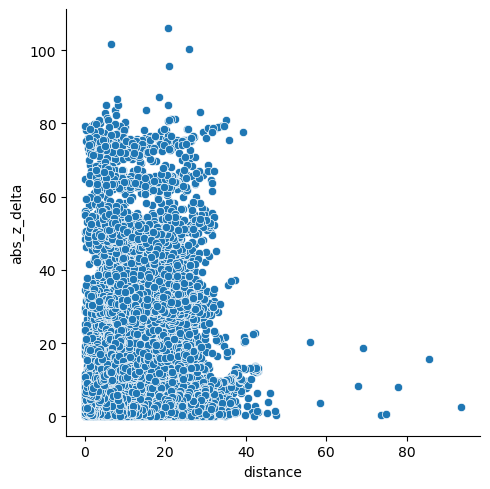

In [86]:
sns.relplot(data=df, x='distance', y='abs_z_delta', kind='scatter')

<Axes: xlabel='distance', ylabel='Count'>

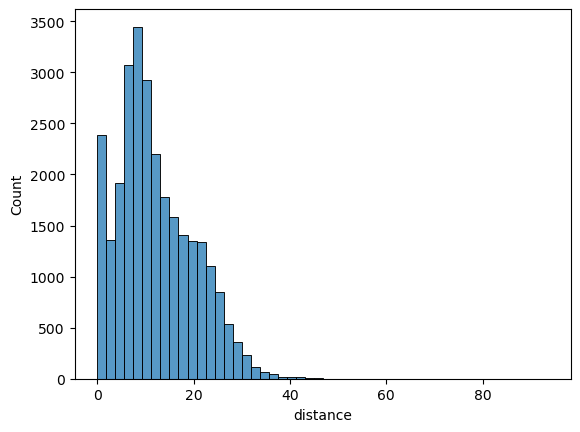

In [87]:
sns.histplot(data=df, x='distance', bins=50)

<Axes: xlabel='z_delta', ylabel='Count'>

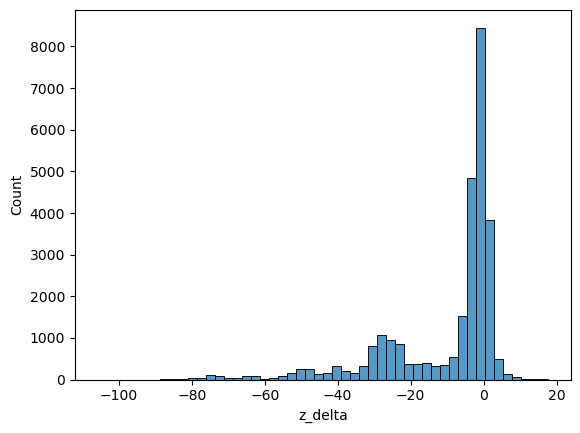

In [88]:
sns.histplot(data=df, x='z_delta', bins=50)

<Axes: xlabel='abs_z_delta', ylabel='Count'>

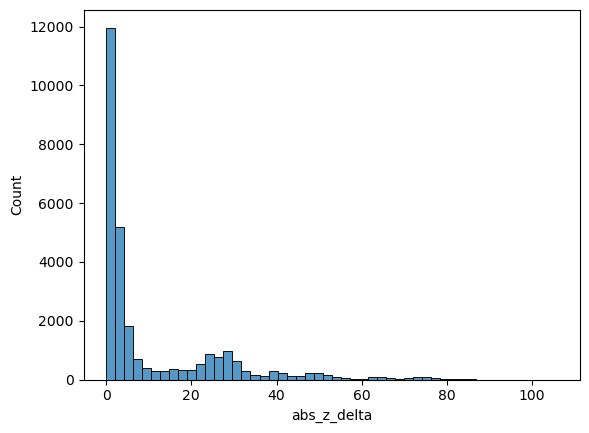

In [89]:
sns.histplot(data=df, x='abs_z_delta', bins=50)